### 环境导入

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### 数据集
使用MNIST数据集来进行测试，这是含有0-9的手写数字的数据集

In [2]:
dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=torchvision.transforms.ToTensor())

In [3]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([8, 7, 3, 2, 7, 4, 4, 7])


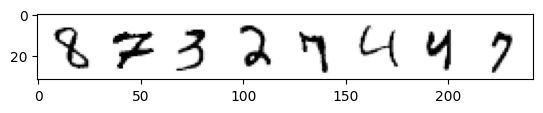

In [4]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

### 损坏过程

In [5]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

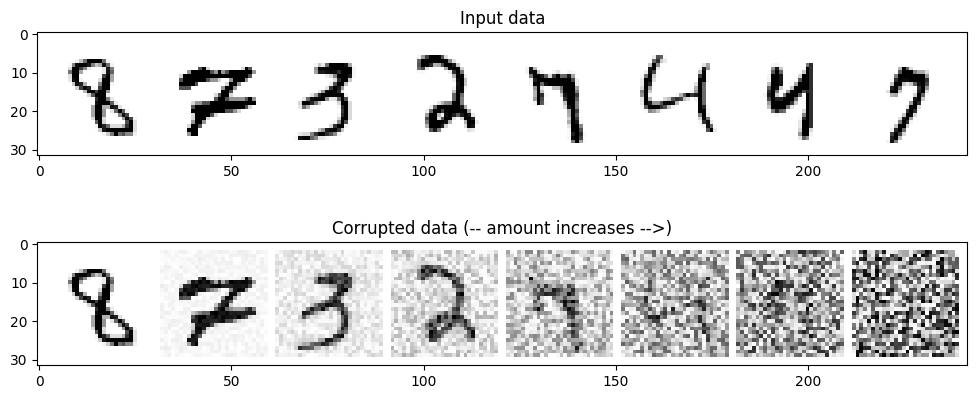

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

### 模型
在这个demo中，我们构建一个最简单的UNet网络，他接受一个单通道的图像，并通过下行路径上的三个卷积层和上行路径上的三个卷积层，在下行和上行层之间具有残差链接。我们将使用max pooling进行下采样和nn.Upsample用于上采样。

In [7]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer
              
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
            
        return x

In [8]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [9]:
sum([p.numel() for p in net.parameters()])

309057

### 训练模型
选择这样一个简单的框架：给定一个损坏的输入noisy_x， 模型应该输出它对原本x的最佳猜测。通过均方误差将预测与真实值进行比较。

训练过程大致如下：
- 获取一批数据
- 添加随机噪声
- 将数据输入模型
- 将模型预测与干净图像进行对比，以计算loss
- 更新模型的参数

Finished epoch 0. Average loss for this epoch: 0.024917
Finished epoch 1. Average loss for this epoch: 0.019424
Finished epoch 2. Average loss for this epoch: 0.017930


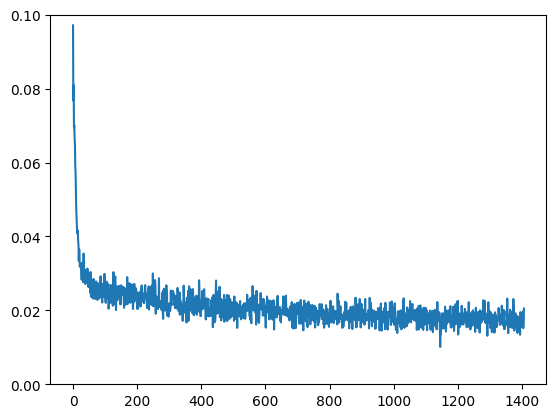

In [10]:
# DataLoader
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 训练轮数
n_epochs = 3

# 加载模型
net = BasicUNet()
net.to(device)

# 损失函数
loss_fn = nn.MSELoss()

# 优化器
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# 训练
losses = []

for epoch in range(n_epochs):

    for x, y in train_dataloader:

        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)
        
        pred = net(noisy_x)

        loss = loss_fn(pred, x) 

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

plt.plot(losses)
plt.ylim(0, 0.1);

训练完成后，尝试抓取一批数据喂进模型观察结果

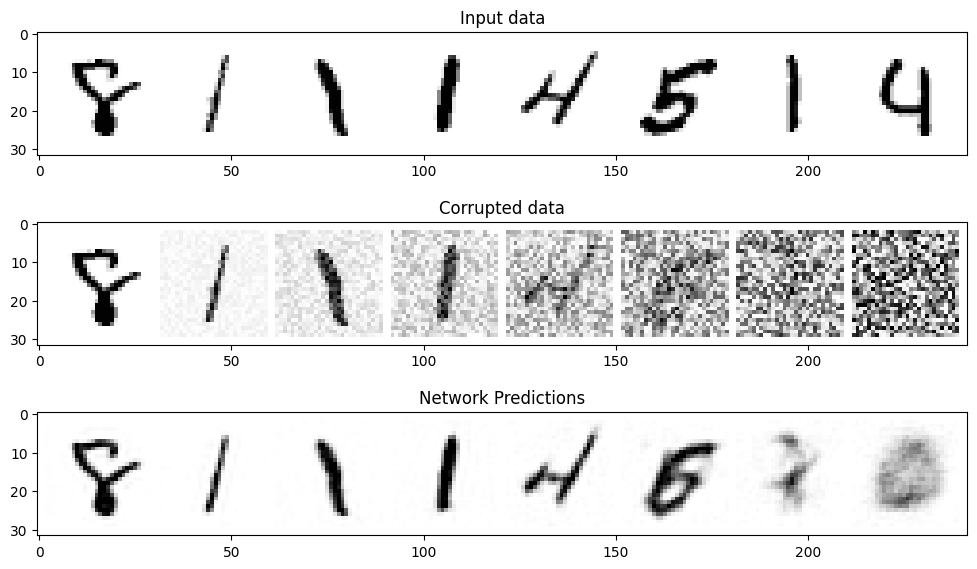

In [11]:
# 获取数据
x, y = next(iter(train_dataloader))
x = x[:8] # 获取前8个样本

amount = torch.linspace(0, 1, x.shape[0]) # 创建一个从0到1的向量
noised_x = corrupt(x, amount) # 使用向量中的值对数据进行损坏

with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu() # 使用网络对损坏的数据进行预测

# 绘制结果
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');